# Set Up
Run this code to prepare notebook
It defines functions and imports libraries

In [1]:
#!/usr/bin/env python
# encoding: utf-8

"""
code based on modules from pypercolate
"""

from __future__ import (absolute_import, division,
                        print_function, unicode_literals)

import scipy
import timeit
import copy
import numpy as np
import scipy.stats
import networkx as nx
import matplotlib.pyplot as plt

alpha_1sigma = 2 * scipy.stats.norm.cdf(-2.0)
"""
The alpha for the 1 sigma confidence level
"""

'\nThe alpha for the 1 sigma confidence level\n'

In [2]:
def _microcanonical_average_spanning_cluster(has_spanning_cluster, alpha):
    r'''
    Compute the average number of runs that have a spanning cluster

    Helper function for :func:`microcanonical_averages`

    Parameters
    ----------

    has_spanning_cluster : 1-D :py:class:`numpy.ndarray` of bool
        Each entry is the ``has_spanning_cluster`` field of the output of
        :func:`sample_states`:
        An entry is ``True`` if there is a spanning cluster in that respective
        run, and ``False`` otherwise.

    alpha : float
        Significance level.

    Returns
    -------

    ret : dict
        Spanning cluster statistics

    ret['spanning_cluster'] : float
        The average relative number (Binomial proportion) of runs that have a
        spanning cluster.
        This is the Bayesian point estimate of the posterior mean, with a
        uniform prior.

    ret['spanning_cluster_ci'] : 1-D :py:class:`numpy.ndarray` of float, size 2
        The lower and upper bounds of the Binomial proportion confidence
        interval with uniform prior.

    See Also
    --------

    sample_states : spanning cluster detection

    microcanonical_averages : spanning cluster statistics

    Notes
    -----

    Averages and confidence intervals for Binomial proportions

    As Cameron [8]_ puts it, the normal approximation to the confidence
    interval for a Binomial proportion :math:`p` "suffers a *systematic*
    decline in performance (...) towards extreme values of :math:`p` near
    :math:`0` and :math:`1`, generating binomial [confidence intervals]
    with effective coverage far below the desired level." (see also
    References [6]_ and [7]_).

    A different approach to quantifying uncertainty is Bayesian inference.
    [5]_
    For :math:`n` independent Bernoulli trails with common success
    probability :math:`p`, the *likelihood* to have :math:`k` successes
    given :math:`p` is the binomial distribution

    .. math::

        P(k|p) = \binom{n}{k} p^k (1-p)^{n-k} \equiv B(a,b),

    where :math:`B(a, b)` is the *Beta distribution* with parameters
    :math:`a = k + 1` and :math:`b = n - k + 1`.
    Assuming a uniform prior :math:`P(p) = 1`, the *posterior* is [5]_

    .. math::

        P(p|k) = P(k|p)=B(a,b).

    A point estimate is the posterior mean

    .. math::

        \bar{p} = \frac{k+1}{n+2}

    with the :math:`1 - \alpha` credible interval :math:`(p_l, p_u)` given
    by

    .. math::

        \int_0^{p_l} dp B(a,b) = \int_{p_u}^1 dp B(a,b) = \frac{\alpha}{2}.

    References
    ----------

    .. [5] Wasserman, L. All of Statistics (Springer New York, 2004),
       `doi:10.1007/978-0-387-21736-9 <http://dx.doi.org/10.1007/978-0-387-21736-9>`_.

    .. [6] DasGupta, A., Cai, T. T. & Brown, L. D. Interval Estimation for a
       Binomial Proportion. Statistical Science 16, 101-133 (2001).
       `doi:10.1214/ss/1009213286 <http://dx.doi.org/10.1214/ss/1009213286>`_.

    .. [7] Agresti, A. & Coull, B. A. Approximate is Better than "Exact" for
       Interval Estimation of Binomial Proportions. The American Statistician
       52, 119-126 (1998),
       `doi:10.2307/2685469 <http://dx.doi.org/10.2307/2685469>`_.

    .. [8] Cameron, E. On the Estimation of Confidence Intervals for Binomial
       Population Proportions in Astronomy: The Simplicity and Superiority of
       the Bayesian Approach. Publications of the Astronomical Society of
       Australia 28, 128-139 (2011),
       `doi:10.1071/as10046 <http://dx.doi.org/10.1071/as10046>`_.

    '''

    ret = dict()
    runs = has_spanning_cluster.size

    # Bayesian posterior mean for Binomial proportion (uniform prior)
    k = has_spanning_cluster.sum(dtype=float)
    ret['spanning_cluster'] = (
        (k + 1) / (runs + 2)
    )

    # Bayesian credible interval for Binomial proportion (uniform
    # prior)
    ret['spanning_cluster_ci'] = scipy.stats.beta.ppf(
        [alpha / 2, 1 - alpha / 2], k + 1, runs - k + 1
    )

    return ret

In [3]:
def _microcanonical_average_max_cluster_size(max_cluster_size, alpha):
    """
    Compute the average size of the largest cluster

    Helper function for :func:`microcanonical_averages`

    Parameters
    ----------

    max_cluster_size : 1-D :py:class:`numpy.ndarray` of int
        Each entry is the ``max_cluster_size`` field of the output of
        :func:`sample_states`:
        The size of the largest cluster (absolute number of sites).

    alpha: float
        Significance level.

    Returns
    -------

    ret : dict
        Largest cluster statistics

    ret['max_cluster_size'] : float
        Average size of the largest cluster (absolute number of sites)

    ret['max_cluster_size_ci'] : 1-D :py:class:`numpy.ndarray` of float, size 2
        Lower and upper bounds of the normal confidence interval of the average
        size of the largest cluster (absolute number of sites)

    See Also
    --------

    sample_states : largest cluster detection

    microcanonical_averages : largest cluster statistics
    """

    ret = dict()
    runs = max_cluster_size.size
    sqrt_n = np.sqrt(runs)

    max_cluster_size_sample_mean = max_cluster_size.mean()
    ret['max_cluster_size'] = max_cluster_size_sample_mean

    max_cluster_size_sample_std = max_cluster_size.std(ddof=1)
    if max_cluster_size_sample_std:
        old_settings = np.seterr(all='raise')
        ret['max_cluster_size_ci'] = scipy.stats.t.interval(
            1 - alpha,
            df=runs - 1,
            loc=max_cluster_size_sample_mean,
            scale=max_cluster_size_sample_std / sqrt_n
        )
        np.seterr(**old_settings)
    else:
        ret['max_cluster_size_ci'] = (
            max_cluster_size_sample_mean * np.ones(2)
        )

    return ret

In [4]:
def _microcanonical_average_moments(moments, alpha):
    """
    Compute the average moments of the cluster size distributions

    Helper function for :func:`microcanonical_averages`

    Parameters
    ----------

    moments : 2-D :py:class:`numpy.ndarray` of int
        ``moments.shape[1] == 5`.
        Each array ``moments[r, :]`` is the ``moments`` field of the output of
        :func:`sample_states`:
        The ``k``-th entry is the ``k``-th raw moment of the (absolute) cluster
        size distribution.

    alpha: float
        Significance level.

    Returns
    -------

    ret : dict
        Moment statistics

    ret['moments'] : 1-D :py:class:`numpy.ndarray` of float, size 5
        The ``k``-th entry is the average ``k``-th raw moment of the (absolute)
        cluster size distribution, with ``k`` ranging from ``0`` to ``4``.

    ret['moments_ci'] : 2-D :py:class:`numpy.ndarray` of float, shape (5,2)
        ``ret['moments_ci'][k]`` are the lower and upper bounds of the normal
        confidence interval of the average ``k``-th raw moment of the
        (absolute) cluster size distribution, with ``k`` ranging from ``0`` to
        ``4``.

    See Also
    --------

    sample_states : computation of moments

    microcanonical_averages : moment statistics
    """

    ret = dict()
    runs = moments.shape[0]
    sqrt_n = np.sqrt(runs)

    moments_sample_mean = moments.mean(axis=0)
    ret['moments'] = moments_sample_mean

    moments_sample_std = moments.std(axis=0, ddof=1)
    ret['moments_ci'] = np.empty((5, 2))
    for k in range(5):
        if moments_sample_std[k]:
            old_settings = np.seterr(all='raise')
            ret['moments_ci'][k] = scipy.stats.t.interval(
                1 - alpha,
                df=runs - 1,
                loc=moments_sample_mean[k],
                scale=moments_sample_std[k] / sqrt_n
            )
            np.seterr(**old_settings)
        else:
            ret['moments_ci'][k] = (
                moments_sample_mean[k] * np.ones(2)
            )

    return ret

In [5]:
def spanning_2d_grid(length):
    """
    Generate a square lattice with auxiliary nodes for spanning detection

    Parameters
    ----------

    length : int
       Number of nodes in one dimension, excluding the auxiliary nodes.

    Returns
    -------

    networkx.Graph
       A square lattice graph with auxiliary nodes for spanning cluster
       detection

    See Also
    --------

    sample_states : spanning cluster detection

    """
    ret = nx.grid_2d_graph(length + 2, length)

    for i in range(length):
        # side 0
        ret.nodes[(0, i)]['span'] = 0
        ret[(0, i)][(1, i)]['span'] = 0

        # side 1
        ret.nodes[(length + 1, i)]['span'] = 1
        ret[(length + 1, i)][(length, i)]['span'] = 1

    return ret

In [6]:
def microcanonical_averages(
    graph, runs=40, spanning_cluster=True, model='bond', alpha=alpha_1sigma,
    copy_result=True
):
    r'''
    Generate successive microcanonical percolation ensemble averages

    This is a :ref:`generator function <python:tut-generators>` to successively
    add one edge at a time from the graph to the percolation model for a number
    of independent runs in parallel.
    At each iteration, it calculates and returns the averaged cluster
    statistics.

    Parameters
    ----------
    graph : networkx.Graph
        The substrate graph on which percolation is to take place

    runs : int, optional
        Number of independent runs.
        Defaults to ``40``.

    spanning_cluster : bool, optional
        Defaults to ``True``.

    model : str, optional
        The percolation model (either ``'bond'`` or ``'site'``).
        Defaults to ``'bond'``.

        .. note:: Other models than ``'bond'`` are not supported yet.

    alpha: float, optional
        Significance level.
        Defaults to 1 sigma of the normal distribution.
        ``1 - alpha`` is the confidence level.

    copy_result : bool, optional
        Whether to return a copy or a reference to the result dictionary.
        Defaults to ``True``.

    Yields
    ------
    ret : dict
        Cluster statistics

    ret['n'] : int
        Number of occupied bonds

    ret['N'] : int
        Total number of sites

    ret['M'] : int
        Total number of bonds

    ret['spanning_cluster'] : float
        The average number (Binomial proportion) of runs that have a spanning
        cluster.
        This is the Bayesian point estimate of the posterior mean, with a
        uniform prior.
        Only exists if `spanning_cluster` is set to ``True``.

    ret['spanning_cluster_ci'] : 1-D :py:class:`numpy.ndarray` of float, size 2
        The lower and upper bounds of the Binomial proportion confidence
        interval with uniform prior.
        Only exists if `spanning_cluster` is set to ``True``.

    ret['max_cluster_size'] : float
        Average size of the largest cluster (absolute number of sites)

    ret['max_cluster_size_ci'] : 1-D :py:class:`numpy.ndarray` of float, size 2
        Lower and upper bounds of the normal confidence interval of the average
        size of the largest cluster (absolute number of sites)

    ret['moments'] : 1-D :py:class:`numpy.ndarray` of float, size 5
        The ``k``-th entry is the average ``k``-th raw moment of the (absolute)
        cluster size distribution, with ``k`` ranging from ``0`` to ``4``.

    ret['moments_ci'] : 2-D :py:class:`numpy.ndarray` of float, shape (5,2)
        ``ret['moments_ci'][k]`` are the lower and upper bounds of the normal
        confidence interval of the average ``k``-th raw moment of the
        (absolute) cluster size distribution, with ``k`` ranging from ``0`` to
        ``4``.

    Raises
    ------
    ValueError
        If `runs` is not a positive integer

    ValueError
        If `alpha` is not a float in the interval (0, 1)

    See also
    --------

    sample_states

    percolate.percolate._microcanonical_average_spanning_cluster

    percolate.percolate._microcanonical_average_max_cluster_size

    Notes
    -----
    Iterating through this generator corresponds to several parallel runs of
    the Newman-Ziff algorithm.
    Each iteration yields a microcanonical percolation ensemble for the number
    :math:`n` of occupied bonds. [9]_
    The first iteration yields the trivial microcanonical percolation ensemble
    with :math:`n = 0` occupied bonds.

    Spanning cluster

        .. seealso:: :py:func:`sample_states`

    Raw moments of the cluster size distribution

        .. seealso:: :py:func:`sample_states`


    References
    ----------
    .. [9] Newman, M. E. J. & Ziff, R. M. Fast monte carlo algorithm for site
        or bond percolation. Physical Review E 64, 016706+ (2001),
        `doi:10.1103/physreve.64.016706 <http://dx.doi.org/10.1103/physreve.64.016706>`_.

    '''

    try:
        runs = int(runs)
    except:
        raise ValueError("runs needs to be a positive integer")

    if runs <= 0:
        raise ValueError("runs needs to be a positive integer")

    try:
        alpha = float(alpha)
    except:
        raise ValueError("alpha needs to be a float in the interval (0, 1)")

    if alpha <= 0.0 or alpha >= 1.0:
        raise ValueError("alpha needs to be a float in the interval (0, 1)")

    # initial iteration
    # we do not need a copy of the result dictionary since we copy the values
    # anyway
    run_iterators = [sample_states(graph, spanning_cluster=spanning_cluster, model=model, copy_result=False)
        for _ in range(runs)]

    ret = dict()
    for microcanonical_ensemble in zip(*run_iterators):
        # merge cluster statistics
        ret['n'] = microcanonical_ensemble[0]['n']
        ret['N'] = microcanonical_ensemble[0]['N']
        ret['M'] = microcanonical_ensemble[0]['M']

        max_cluster_size = np.empty(runs)
        moments = np.empty((runs, 5))
        if spanning_cluster:
            has_spanning_cluster = np.empty(runs)

        for r, state in enumerate(microcanonical_ensemble):
            assert state['n'] == ret['n']
            assert state['N'] == ret['N']
            assert state['M'] == ret['M']
            max_cluster_size[r] = state['max_cluster_size']
            moments[r] = state['moments']
            if spanning_cluster:
                has_spanning_cluster[r] = state['has_spanning_cluster']

        ret.update(_microcanonical_average_max_cluster_size(max_cluster_size, alpha))

        ret.update(_microcanonical_average_moments(moments, alpha))

        if spanning_cluster:
            ret.update(_microcanonical_average_spanning_cluster(has_spanning_cluster, alpha))

        if copy_result:
            yield copy.deepcopy(ret)
        else:
            yield ret

In [7]:
def sample_states( graph, spanning_cluster=True, model='bond', copy_result=True):
    '''
    Generate successive sample states of the percolation model

    This is a :ref:`generator function <python:tut-generators>` to successively
    add one edge at a time from the graph to the percolation model.
    At each iteration, it calculates and returns the cluster statistics.

    Parameters
    ----------
    graph : networkx.Graph
        The substrate graph on which percolation is to take place

    spanning_cluster : bool, optional
        Whether to detect a spanning cluster or not.
        Defaults to ``True``.

    model : str, optional
        The percolation model (either ``'bond'`` or ``'site'``).
        Defaults to ``'bond'``.

        .. note:: Other models than ``'bond'`` are not supported yet.

    copy_result : bool, optional
        Whether to return a copy or a reference to the result dictionary.
        Defaults to ``True``.

    Yields
    ------
    ret : dict
        Cluster statistics

    ret['n'] : int
        Number of occupied bonds

    ret['N'] : int
        Total number of sites

    ret['M'] : int
        Total number of bonds

    ret['has_spanning_cluster'] : bool
        ``True`` if there is a spanning cluster, ``False`` otherwise.
        Only exists if `spanning_cluster` argument is set to ``True``.

    ret['max_cluster_size'] : int
        Size of the largest cluster (absolute number of sites)

    ret['moments'] : 1-D :py:class:`numpy.ndarray` of int
        Array of size ``5``.
        The ``k``-th entry is the ``k``-th raw moment of the (absolute) cluster
        size distribution, with ``k`` ranging from ``0`` to ``4``.

    Raises
    ------
    ValueError
        If `model` does not equal ``'bond'``.

    ValueError
        If `spanning_cluster` is ``True``, but `graph` does not contain any
        auxiliary nodes to detect spanning clusters.

    See also
    --------

    microcanonical_averages : Evolves multiple sample states in parallel

    Notes
    -----
    Iterating through this generator is a single run of the Newman-Ziff
    algorithm. [2]_
    The first iteration yields the trivial state with :math:`n = 0` occupied
    bonds.

    Spanning cluster

        In order to detect a spanning cluster, `graph` needs to contain
        auxiliary nodes and edges, cf. Reference [2]_, Figure 6.
        The auxiliary nodes and edges have the ``'span'`` `attribute
        <http://networkx.github.io/documentation/latest/tutorial/tutorial.html#node-attributes>`_.
        The value is either ``0`` or ``1``, distinguishing the two sides of the
        graph to span.

    Raw moments of the cluster size distribution

        The :math:`k`-th raw moment of the (absolute) cluster size distribution
        is :math:`\sum_s' s^k N_s`, where :math:`s` is the cluster size and
        :math:`N_s` is the number of clusters of size :math:`s`. [3]_
        The primed sum :math:`\sum'` signifies that the largest cluster is
        excluded from the sum. [4]_

    References
    ----------
    .. [2] Newman, M. E. J. & Ziff, R. M. Fast monte carlo algorithm for site
        or bond percolation. Physical Review E 64, 016706+ (2001),
        `doi:10.1103/physreve.64.016706 <http://dx.doi.org/10.1103/physreve.64.016706>`_.

    .. [3] Stauffer, D. & Aharony, A. Introduction to Percolation Theory (Taylor &
       Francis, London, 1994), second edn.

    .. [4] Binder, K. & Heermann, D. W. Monte Carlo Simulation in Statistical
       Physics (Springer, Berlin, Heidelberg, 2010),
       `doi:10.1007/978-3-642-03163-2 <http://dx.doi.org/10.1007/978-3-642-03163-2>`_.
    '''

    if model != 'bond':
        raise ValueError('Only bond percolation supported.')

    if spanning_cluster:
        auxiliary_node_attributes = nx.get_node_attributes(graph, 'span')
        auxiliary_nodes = auxiliary_node_attributes.keys()
        if not list(auxiliary_nodes):
            raise ValueError('Spanning cluster is to be detected, but no auxiliary nodes given.')

        spanning_sides = list(set(auxiliary_node_attributes.values()))
        if len(spanning_sides) != 2:
            raise ValueError('Spanning cluster is to be detected, but auxiliary nodes '
                'of less or more than 2 types (sides) given.')

        auxiliary_edge_attributes = nx.get_edge_attributes(graph, 'span')

    # get subgraph on which percolation is to take place (strip off the auxiliary nodes)
    if spanning_cluster:
        perc_graph = graph.subgraph([node for node in graph.__iter__()
                if 'span' not in graph.nodes[node]])
    else:
        perc_graph = graph

    # get a list of edges for easy access in later iterations
    perc_edges = perc_graph.edges()

    # number of nodes N
    num_nodes = nx.number_of_nodes(perc_graph)

    # number of edges M
    num_edges = nx.number_of_edges(perc_graph)

    # initial iteration: no edges added yet (n == 0)
    ret = dict()

    ret['n'] = 0
    ret['N'] = num_nodes
    ret['M'] = num_edges
    ret['max_cluster_size'] = 1
    ret['moments'] = np.ones(5) * (num_nodes - 1)

    if spanning_cluster:
        ret['has_spanning_cluster'] = False

    if copy_result:
        yield copy.deepcopy(ret)
    else:
        yield ret

    # permute edges
    perm_edges = np.random.permutation(num_edges)

    # set up disjoint set (union-find) data structure
    ds = nx.utils.union_find.UnionFind()

    if spanning_cluster:
        ds_spanning = nx.utils.union_find.UnionFind()

        # merge all auxiliary nodes for each side
        side_roots = dict()
        for side in spanning_sides:
            nodes = [node for (node, node_side) in auxiliary_node_attributes.items()
                if node_side is side]

            ds_spanning.union(*nodes)
            side_roots[side] = ds_spanning[nodes[0]]

        for (edge, edge_side) in auxiliary_edge_attributes.items():
            ds_spanning.union(side_roots[edge_side], *edge)

        side_roots = [ds_spanning[side_root] for side_root in side_roots.values()]

    # get first node
    max_cluster_root = next(perc_graph.__iter__())

    # loop over all edges (n == 1..M)
    for n in range(num_edges):
        ret['n'] = n + 1

        # draw new edge from permutation
        edge_index = perm_edges[n]
        perc_edges = np.array(perc_edges)
        edge = perc_edges[edge_index]
        ret['edge'] = edge

        # find roots and weights
        roots = [ds.__getitem__(tuple([node[0], node[1]])) for node in edge]
        weights = [ds.weights[root] for root in roots]

        if roots[0] is not roots[1]:
            # not same cluster: union!
            ds.union(roots[0],roots[1])
            if spanning_cluster:
                ds_spanning.union(roots[0],roots[1])

                ret['has_spanning_cluster'] = (ds_spanning[side_roots[0]] == ds_spanning[side_roots[1]])

           # find new root and weight
            root = tuple([ds[edge[1][0]],ds[edge[1][1]]])
            rt = list(ds.to_sets())
            k = 0
            weight = 0
            for k in rt:
             for j in k:
              if type(j) == tuple:
               if j[0] == root[0] and j[1] == root[1]:
                weight = len(k)

            #deduct the previous sub-maximum clusters from moments
            for i in [0, 1]:
                if roots[i] is max_cluster_root:
                    continue
                ret['moments'] -= weights[i] ** np.arange(5)

            if max_cluster_root in roots:
                # merged with maximum cluster
                max_cluster_root = root
                ret['max_cluster_size'] = weight

            else:
                # merged previously sub-maximum clusters
                if ret['max_cluster_size'] >= weight:
                    # previously largest cluster remains largest cluster
                    # add merged cluster to moments
                    ret['moments'] += weight ** np.arange(5)
                else:
                    # merged cluster overtook previously largest cluster
                    # add previously largest cluster to moments
                    max_cluster_root = root
                    ret['moments'] += ret['max_cluster_size'] ** np.arange(5)
                    ret['max_cluster_size'] = weight

        if copy_result:
            yield copy.deepcopy(ret)
        else:
            yield ret

In [8]:
def microcanonical_averages_arrays(microcanonical_averages):
    """
    Compile microcanonical averages over all iteration steps into single arrays

    Helper function to aggregate the microcanonical averages over all iteration
    steps into single arrays for further processing

    Parameters
    ----------

    microcanonical_averages : iterable
       Typically, this is the :func:`microcanonical_averages` generator

    Returns
    -------

    ret : dict
       Aggregated cluster statistics

    ret['N'] : int
        Total number of sites

    ret['M'] : int
        Total number of bonds

    ret['spanning_cluster'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation probability:
        The normalized average number of runs that have a spanning cluster.

    ret['spanning_cluster_ci'] : 2-D :py:class:`numpy.ndarray` of float, size 2
        The lower and upper bounds of the percolation probability.

    ret['max_cluster_size'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation strength:
        Average relative size of the largest cluster

    ret['max_cluster_size_ci'] : 2-D :py:class:`numpy.ndarray` of float
        Lower and upper bounds of the normal confidence interval of the
        percolation strength.

    ret['moments'] : 2-D :py:class:`numpy.ndarray` of float, shape (5, M + 1)
        Average raw moments of the (relative) cluster size distribution.

    ret['moments_ci'] : 3-D :py:class:`numpy.ndarray` of float, shape (5, M + 1, 2)
        Lower and upper bounds of the normal confidence interval of the raw
        moments of the (relative) cluster size distribution.

    See Also
    --------

    microcanonical_averages

    """

    ret = dict()

    for n, microcanonical_average in enumerate(microcanonical_averages):
        assert n == microcanonical_average['n']

        if n == 0:
            num_edges = microcanonical_average['M']
            num_sites = microcanonical_average['N']
            spanning_cluster = ('spanning_cluster' in microcanonical_average)
            ret['max_cluster_size'] = np.empty(num_edges + 1)
            ret['max_cluster_size_ci'] = np.empty((num_edges + 1, 2))

            if spanning_cluster:
                ret['spanning_cluster'] = np.empty(num_edges + 1)
                ret['spanning_cluster_ci'] = np.empty((num_edges + 1, 2))

            ret['moments'] = np.empty((5, num_edges + 1))
            ret['moments_ci'] = np.empty((5, num_edges + 1, 2))

        ret['max_cluster_size'][n] = microcanonical_average['max_cluster_size']
        ret['max_cluster_size_ci'][n] = (microcanonical_average['max_cluster_size_ci'])

        if spanning_cluster:
            ret['spanning_cluster'][n] = (microcanonical_average['spanning_cluster'])
            ret['spanning_cluster_ci'][n] = (microcanonical_average['spanning_cluster_ci'])

        ret['moments'][:, n] = microcanonical_average['moments']
        ret['moments_ci'][:, n] = microcanonical_average['moments_ci']

    # normalize by number of sites
    for key in ret:
        if 'spanning_cluster' in key:
            continue
        ret[key] /= num_sites

    ret['M'] = num_edges
    ret['N'] = num_sites
    return ret


In [9]:
def canonical_averages(ps, microcanonical_averages_arrays):
    """
    Compute the canonical cluster statistics from microcanonical statistics

    This is according to Newman and Ziff, Equation (2).
    Note that we also simply average the bounds of the confidence intervals
    according to this formula.

    Parameters
    ----------

    ps : iterable of float
       Each entry is a probability for which to form the canonical ensemble
       and compute the weighted statistics from the microcanonical statistics

    microcanonical_averages_arrays
       Typically the output of :func:`microcanonical_averages_arrays`

    Returns
    -------

    ret : dict
       Canonical ensemble cluster statistics

    ret['ps'] : iterable of float
        The parameter `ps`

    ret['N'] : int
        Total number of sites

    ret['M'] : int
        Total number of bonds

    ret['spanning_cluster'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation probability:
        The normalized average number of runs that have a spanning cluster.

    ret['spanning_cluster_ci'] : 2-D :py:class:`numpy.ndarray` of float, size 2
        The lower and upper bounds of the percolation probability.

    ret['max_cluster_size'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation strength:
        Average relative size of the largest cluster

    ret['max_cluster_size_ci'] : 2-D :py:class:`numpy.ndarray` of float
        Lower and upper bounds of the normal confidence interval of the
        percolation strength.

    ret['moments'] : 2-D :py:class:`numpy.ndarray` of float, shape (5, M + 1)
        Average raw moments of the (relative) cluster size distribution.

    ret['moments_ci'] : 3-D :py:class:`numpy.ndarray` of float, shape (5, M + 1, 2)
        Lower and upper bounds of the normal confidence interval of the raw
        moments of the (relative) cluster size distribution.

    See Also
    --------

    microcanonical_averages

    microcanonical_averages_arrays


    """

    num_sites = microcanonical_averages_arrays['N']
    num_edges = microcanonical_averages_arrays['M']
    spanning_cluster = ('spanning_cluster' in microcanonical_averages_arrays)

    ret = dict()
    ret['ps'] = ps
    ret['N'] = num_sites
    ret['M'] = num_edges

    ret['max_cluster_size'] = np.empty(ps.size)
    ret['max_cluster_size_ci'] = np.empty((ps.size, 2))

    if spanning_cluster:
        ret['spanning_cluster'] = np.empty(ps.size)
        ret['spanning_cluster_ci'] = np.empty((ps.size, 2))

    ret['moments'] = np.empty((5, ps.size))
    ret['moments_ci'] = np.empty((5, ps.size, 2))

    for p_index, p in enumerate(ps):
        binomials = _binomial_pmf(n=num_edges, p=p)

        for key, value in microcanonical_averages_arrays.items():
            if len(key) <= 1:
                continue

            if key in ['max_cluster_size', 'spanning_cluster']:
                ret[key][p_index] = np.sum(binomials * value)
            elif key in ['max_cluster_size_ci', 'spanning_cluster_ci']:
                ret[key][p_index] = np.sum(
                    np.tile(binomials, (2, 1)).T * value, axis=0
                )
            elif key == 'moments':
                ret[key][:, p_index] = np.sum(
                    np.tile(binomials, (5, 1)) * value, axis=1
                )
            elif key == 'moments_ci':
                ret[key][:, p_index] = np.sum(
                    np.rollaxis(np.tile(binomials, (5, 2, 1)), 2, 1) * value,
                    axis=1
                )
            else:
                raise NotImplementedError(
                    '{}-dimensional array'.format(value.ndim)
                )

    return ret

In [10]:
def _binomial_pmf(n, p):
    """
    Compute the binomial PMF according to Newman and Ziff

    Helper function for :func:`canonical_averages`

    See Also
    --------

    canonical_averages

    Notes
    -----

    See Newman & Ziff, Equation (10) [10]_

    References
    ----------

    .. [10] Newman, M. E. J. & Ziff, R. M. Fast monte carlo algorithm for site
        or bond percolation. Physical Review E 64, 016706+ (2001),
        `doi:10.1103/physreve.64.016706 <http://dx.doi.org/10.1103/physreve.64.016706>`_.

    """

    n = int(n)
    ret = np.empty(n + 1)

    nmax = int(np.round(p * n))

    ret[nmax] = 1.0

    old_settings = np.seterr(under='ignore')  # seterr to known value

    for i in range(nmax + 1, n + 1):
        ret[i] = ret[i - 1] * (n - i + 1.0) / i * p / (1.0 - p)

    for i in range(nmax - 1, -1, -1):
        ret[i] = ret[i + 1] * (i + 1.0) / (n - i) * (1.0 - p) / p

    ret = ret / ret.sum()
    np.seterr(**old_settings)  # reset to default

    return ret

In [11]:
def Canonical_Simulation(grid_runs,grid_ls,grid_ps_arrays):
  """
    This is the master function which pulls together all the other functions needed to simulate percolation
    It creates arrays to store data; it then evolves the lattice and works with the microcanonical ensemble;
    it then transforms the data back to the canonical ensemble

    Parameters
    ----------

    grid_runs: integer
       This is the size of the size of the microcanonical ensemble used during the simulation

    grid_ls: interable, containing integers
       This object contains the lengths of each of the chains that are to be simulated

    number_of_ps: integer
       This decides how high the resolution the simulation is in probability space.
       The number given here decides how many different values of probability to return results for

    Returns
    -------
    grid_ls: numpy array
      This returns the list of the legths of the edges of the grids for convenince

    grid_ps_arrays: list
      This returns the list of probability-values used in the simulation

    grid_stats: list
      This returns a list of the outputs for each level of zooming into the critical point

    grid_stats[i]: list
       A list of the data structures for each chain length

    grid_stats[i][j]: dict
       Canonical ensemble cluster statistics for probability interval i and lattice side length j

    grid_stats[i][j]['ps'] : iterable of float
        The parameter `ps` for probability interval i and lattice side length j

    grid_stats[i][j]['N'] : int
        Total number of sites for probability interval i and lattice side length j

    grid_stats[i][j]['M'] : int
        Total number of bonds for probability interval i and lattice side length j

    grid_stats[i][j]['spanning_cluster'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation probability:
        The normalized average number of runs that have a spanning cluster, for probability interval i and lattice side length j

    grid_stats[i][j]['spanning_cluster_ci'] : 2-D :py:class:`numpy.ndarray` of float, size 2
        The lower and upper bounds of the percolation probability, for probability interval i and lattice side length j

    grid_stats[i][j]['max_cluster_size'] : 1-D :py:class:`numpy.ndarray` of float
        The percolation strength:
        Average relative size of the largest cluster, for probability interval i and lattice side length j

    grid_stats[i][j]['max_cluster_size_ci'] : 2-D :py:class:`numpy.ndarray` of float
        Lower and upper bounds of the normal confidence interval of the
        percolation strength, for probability interval i and lattice side length j

    grid_stats[i][j]['moments'] : 2-D :py:class:`numpy.ndarray` of float, shape (5, M + 1)
        Average raw moments of the (relative) cluster size distribution, for probability interval i and lattice side length j

    grid_stats[i][j]['moments_ci'] : 3-D :py:class:`numpy.ndarray` of float, shape (5, M + 1, 2)
        Lower and upper bounds of the normal confidence interval of the raw
        moments of the (relative) cluster size distribution, for probability interval i and lattice side length j

    See Also
    --------

    spanning_2d_grid()
    microcanonical_averages_arrays()
    canonical_averages()

  """
  grid_ls = np.array(grid_ls)
  # generate the square grid graphs with spanning cluster detection
  # for all system sizes
  grid_graphs = [spanning_2d_grid(l) for l in grid_ls]

  # compute the microcanonical averages for all system sizes
  grid_microcanonical_averages = [microcanonical_averages(graph=grid_graph, runs=grid_runs) for grid_graph in grid_graphs]

  # combine microcanonical averages into one array
  grid_microcanonical_averages_arrays = [microcanonical_averages_arrays(avg) for avg in grid_microcanonical_averages]

  # occupation probabilities
  grid_ps_arrays = [ np.linspace(0.5 - x, 0.5 + x, num=grid_ps_arrays) for x in [0.5, 0.05] ]

  # compute canonical averages from microcanonical averages for all occupation probabilities and system sizes
  grid_stats = [[canonical_averages(ps, avg_arrays) for avg_arrays in grid_microcanonical_averages_arrays]
    for ps in grid_ps_arrays]

  return grid_ls, grid_ps_arrays, grid_stats

# Run Simulation and Plot Results
Run a simulation and plot key statistics

In [13]:
#Runs the simulation and generates data
grid_ls, grid_ps_arrays, grid_stats = Canonical_Simulation(grid_runs = 40, grid_ls = [3, 10, 32, 100], grid_ps_arrays = 100)

<ipython-input-14-2e0a41b30f65>:97: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


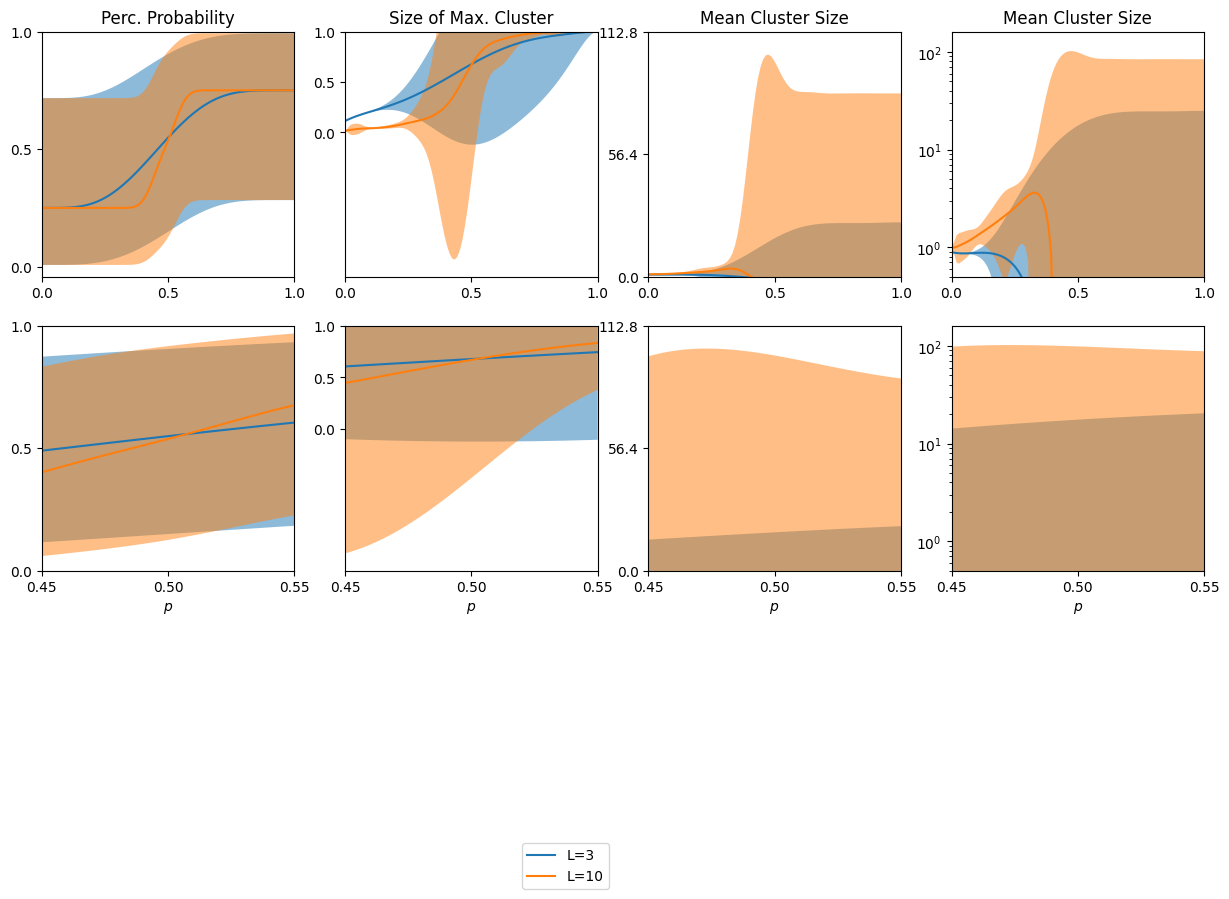

In [14]:
# plots all the data produced
fig, axes = plt.subplots(nrows=len(grid_ps_arrays), ncols=4, squeeze=True, figsize=(15.0, 7.))
for ps_index, ps in enumerate(grid_ps_arrays):
    for l_index, l in enumerate(grid_ls):
        my_stats = grid_stats[ps_index][l_index]

        line, = axes[ps_index, 0].plot(
            ps,
            my_stats['spanning_cluster'],
            rasterized=True,
            label=r'L={}'.format(l),
        )
        axes[ps_index, 0].fill_between(
            ps,
            my_stats['spanning_cluster_ci'].T[1],
            my_stats['spanning_cluster_ci'].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        line, = axes[ps_index, 1].plot(
            ps,
            my_stats['max_cluster_size'],
            rasterized=True,
            label=r'L={}'.format(l),
        )
        axes[ps_index, 1].fill_between(
            ps,
            my_stats['max_cluster_size_ci'].T[1],
            my_stats['max_cluster_size_ci'].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        axes[ps_index, 2].plot(
            ps,
            my_stats['moments'][2],
            rasterized=True,
            label=r'L={}'.format(l),
        )
        axes[ps_index, 2].fill_between(
            ps,
            my_stats['moments_ci'][2].T[1],
            my_stats['moments_ci'][2].T[0],
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )

        axes[ps_index, 3].semilogy(
            ps,
            my_stats['moments'][2],
            rasterized=True,
        )
        axes[ps_index, 3].fill_between(
            ps,
            np.where(
                my_stats['moments_ci'][2].T[1] > 0.0,
                my_stats['moments_ci'][2].T[1],
                0.01
            ),
            np.where(
                my_stats['moments_ci'][2].T[0] > 0.0,
                my_stats['moments_ci'][2].T[0],
                0.01
            ),
            facecolor=line.get_color(),
            alpha=0.5,
            rasterized=True,
        )


    axes[ps_index, 0].set_ylim(ymax=1.0)
    axes[ps_index, 1].set_ylim(ymax=1.0)
    axes[ps_index, 2].set_ylim(ymin=0.0)
    axes[ps_index, 3].set_ylim(ymin=0.5)

    for ax in axes[ps_index, :]:
        ax.set_xlim(xmin=ps.min(), xmax=ps.max())
        ax.set_xticks(np.linspace(ps.min(), ps.max(), num=3))

    for ax in axes[ps_index, :-1]:
        ax.set_yticks(np.linspace(0, ax.get_ylim()[1], num=3))

axes[0, 0].set_title(r'Perc. Probability')
axes[0, 1].set_title(r'Size of Max. Cluster')
axes[0, 2].set_title(r'Mean Cluster Size')
axes[0, 3].set_title(r'Mean Cluster Size')

for ax in axes[-1, :]:
    ax.set_xlabel(r'$p$')

axes[0, 2].legend(frameon=True, loc=(-0.5,-2.5))

plt.tight_layout()
plt.savefig('Percolation Fig 4.5.jpg', dpi = 600, format = 'jpg')
plt.show()

# Phase Transition
Find the critical values of p using prior data, and plot them

In [15]:
#this is a script that takes the output of the simulation and finds the probability at which a phase transition occurs
#this script find the phase transition for each of the 2-D lattices
k = 0
values = []
while k < len(grid_stats[0]):
 i = 0
 while i < len(grid_stats[0][k]['moments'][2]):
  if min(abs(grid_stats[0][k]['moments'][2])) == abs(grid_stats[0][k]['moments'][2][i]):
   values.append(round(grid_stats[0][k]['ps'][i],4))
  i += 1
 k +=1

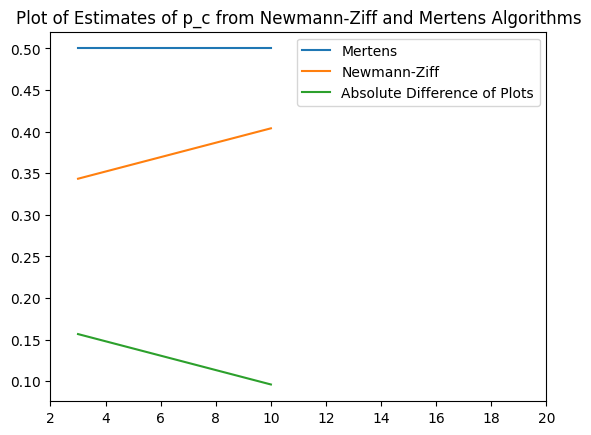

In [16]:
#This script plots the phase transition data, and if possible, plots it alongside published results from another paper for comparision
NZ_plot = np.array(values)
MT_original = np.array((0.5000,0.5412,0.5593,0.5697,0.5758,0.5797,0.5823,0.5842,0.5856,0.5867,0.5875,0.5882,0.5887,0.5892,0.5896,0.5899,0.5902,0.5904,0.5906,0.5908))
MT_plot = []
for i in NZ_plot:
 MT_plot.append(MT_original[int(i-1)])
plt.plot(grid_ls, MT_plot, label = 'Mertens')
plt.plot(grid_ls, NZ_plot, label = 'Newmann-Ziff')
if len(MT_plot) == len(NZ_plot):    #this makes sure that there are no plotting erros due to different array lengths
 plt.plot(grid_ls, abs(NZ_plot-MT_plot), label = 'Absolute Difference of Plots')
plt.xlim(2,20)
plt.title('Plot of Estimates of p_c from Newmann-Ziff and Mertens Algorithms')
plt.legend()
plt.savefig('Fig. 5.jpg', dpi = 600, format = 'jpg')
plt.show()

# Complexity
Find the complexity of the system, and plot it

In [18]:
#containers for data
run_times = []
sides = np.linspace(3,25,23)     #side lengths of grid for percolation

#loop to carry out timing
for L in sides:
 i = 0
 timed = []
 while i < 3:
  time_duration = timeit.timeit(f'Canonical_Simulation(10,{[int(L)]},grid_ps_arrays = 100)', setup='from __main__ import Canonical_Simulation', number=1)
  timed.append(time_duration)
  i += 1
 run_times.append(min(timed))

def f(x,a,b):                 #fitting function
  return a*x**b

(a_,b_), delta = scipy.optimize.curve_fit(f,sides**2,run_times)   #curve fitting
delta_a_ = np.sqrt(np.diag(delta))[0]
delta_b_ = np.sqrt(np.diag(delta))[1]

print('Time = a(L^2)^b')                              #display results
print('a = ', a_, '+/-',delta_a_)
print('a = ', b_, '+/-',delta_b_)

Time = a(L^2)^b
a =  0.01104918529704769 +/- 0.0014974210135155716
a =  0.934384772328103 +/- 0.04490348275924604


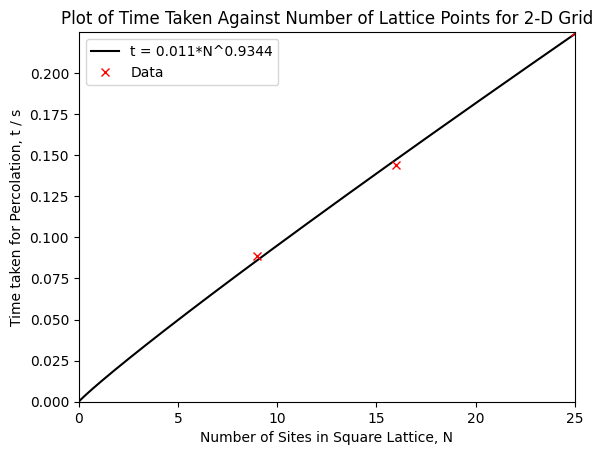

In [19]:
#This cell is designed to plot the complexity curve along with the original data
timelinspace = np.linspace(0,max(sides),200)
plt.plot(timelinspace**2,f(timelinspace**2,a_,b_),color = 'black',label = f't = {round(a_,4)}*N^{round(b_,4)}')
plt.plot(sides**2,run_times, color = 'red', label = 'Data', marker = 'x',linewidth = 0)
plt.xlim(0,max(sides**2))
plt.ylim(0,max(run_times))
plt.xlabel('Number of Sites in Square Lattice, N')
plt.ylabel('Time taken for Percolation, t / s')
plt.title('Plot of Time Taken Against Number of Lattice Points for 2-D Grid')
plt.legend()
plt.plot()
plt.savefig('Percolation Fig 4.3.jpg', dpi = 600, format = 'jpg')